In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.layers import TimeDistributed, Conv1D, MaxPooling1D, Flatten
from keras.optimizers import SGD

Using TensorFlow backend.


In [2]:
df_train = pd.read_csv('train.csv', index_col='Date', parse_dates=['Date'])
df_test = pd.read_csv('test.csv', index_col='Date', parse_dates=['Date'])

In [3]:
df = pd.concat([df_train, df_test])

In [4]:
print(df['Adj Close'].describe())

count    1082.000000
mean     1240.285582
std        72.305660
min      1050.800049
25%      1195.674988
50%      1250.950012
75%      1294.475006
max      1379.000000
Name: Adj Close, dtype: float64


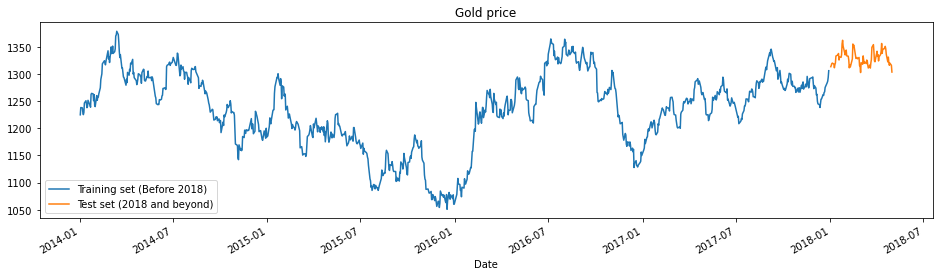

In [5]:
df_train["Adj Close"].plot(figsize=(16,4),legend=True)
df_test["Adj Close"].plot(figsize=(16,4),legend=True)
plt.legend(['Training set (Before 2018)','Test set (2018 and beyond)'])
plt.title('Gold price')
plt.show()

In [6]:
df_train["Adj Close Log"] = df_train.apply(lambda x: np.log(x["Adj Close"]), axis = 1)

In [7]:
df_test["Adj Close Log"] = df_test.apply(lambda x: np.log(x["Adj Close"]), axis = 1)

In [8]:
training_set = df_train.iloc[:,6:7].values
testing_set = df_test.iloc[:,6:7].values

In [9]:
# Scaling the dataset
sc = MinMaxScaler(feature_range=(0,1))
training_set_scaled = sc.fit_transform(training_set)
testing_set_scaled = sc.transform(testing_set)

In [10]:
def plot_predictions(test,predicted):
    plt.plot(test, color='red',label='Actual Gold Price')
    plt.plot(predicted, color='blue',label='Predicted Gold Price')
    plt.title('Gold Price Prediction')
    plt.xlabel('Time')
    plt.ylabel('Gold Price')
    plt.legend()
    plt.show()

def return_rmse(test,predicted):
    mae = mean_absolute_error(test, predicted)
    rmse = mean_squared_error(test, predicted, squared= False)
    print("Mean absolute error, MAE = {}".format(mae))
    print("Root mean squared error, RMSE = {}".format(rmse))

def cal_X_y(dataset, h_id):
    X, y = [], []
    for i in range(h_id,len(dataset)-h_id):
        X.append(dataset[i-h_id:i,0])
        y.append(dataset[i,0])
    X, y = np.array(X), np.array(y)
    return X,y

# Model Predictions for Forecasting Horizon = 4 days

In [11]:
# Forecasting Horizon = 4 days
X_train, y_train = cal_X_y(training_set_scaled, 4)
X_test, y_test = cal_X_y(testing_set_scaled, 4)

In [14]:
X_train[:5]

array([[0.56433111, 0.60435734, 0.60257448, 0.57752218],
       [0.60435734, 0.60257448, 0.57752218, 0.56523215],
       [0.60257448, 0.57752218, 0.56523215, 0.57722298],
       [0.57752218, 0.56523215, 0.57722298, 0.6289328 ],
       [0.56523215, 0.57722298, 0.6289328 , 0.64130663]])

In [15]:
y_train[:5]

array([0.56523215, 0.57722298, 0.6289328 , 0.64130663, 0.62450355])

In [16]:
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1],1)
X_test = X_test.reshape((X_test.shape[0],X_train.shape[1],1))

In [17]:
X_train_re = X_train.reshape((X_train.shape[0],1,X_train.shape[1],1))
X_test_re = X_test.reshape((X_test.shape[0],1,X_train.shape[1],1))

In [18]:
y_train = np.reshape(y_train, (y_train.shape[0],))
y_test = np.reshape(y_test, (y_test.shape[0],))

## Creating CNN-LSTM-1 Model for forecasting horizon = 4

In [19]:
# CNN-LSTM-1 model
model1 = Sequential()
# define CNN model
model1.add(TimeDistributed(Conv1D(filters = 32, kernel_size = 2, activation = 'relu', padding='same'), input_shape = (None,X_train_re.shape[2],1)))
model1.add(TimeDistributed(Conv1D(filters = 64, kernel_size = 2, activation='relu', padding='same')))
model1.add(TimeDistributed(MaxPooling1D(pool_size = 2)))
model1.add(TimeDistributed(Flatten()))
# define LSTM model
model1.add(LSTM(units = 100))
# define the Output layer
model1.add(Dense(1))
# compile the model
model1.compile(optimizer='adam',loss='mean_squared_error')
model1.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_1 (TimeDist (None, None, 4, 32)       96        
_________________________________________________________________
time_distributed_2 (TimeDist (None, None, 4, 64)       4160      
_________________________________________________________________
time_distributed_3 (TimeDist (None, None, 2, 64)       0         
_________________________________________________________________
time_distributed_4 (TimeDist (None, None, 128)         0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               91600     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 95,957
Trainable params:

In [20]:
model1.fit(X_train_re, y_train, epochs=50, batch_size=128, verbose=True)


Epoch 1/50
992/992 [==============================] - 1s 674us/step - loss: 0.3073
Epoch 2/50
992/992 [==============================] - 0s 81us/step - loss: 0.1041
Epoch 3/50
992/992 [==============================] - 0s 79us/step - loss: 0.0187
Epoch 4/50
992/992 [==============================] - 0s 79us/step - loss: 0.0135
Epoch 5/50
992/992 [==============================] - 0s 78us/step - loss: 0.0093
Epoch 6/50
992/992 [==============================] - 0s 76us/step - loss: 0.0054
Epoch 7/50
992/992 [==============================] - 0s 79us/step - loss: 0.0039
Epoch 8/50
992/992 [==============================] - 0s 83us/step - loss: 0.0031
Epoch 9/50
992/992 [==============================] - 0s 83us/step - loss: 0.0025
Epoch 10/50
992/992 [==============================] - 0s 79us/step - loss: 0.0019
Epoch 11/50
992/992 [==============================] - 0s 74us/step - loss: 0.0016
Epoch 12/50
992/992 [==============================] - 0s 77us/step - loss: 0.0014
Epoch 13/50

In [21]:
predicted_y_test = model1.predict(X_test_re)

## Results of CNN-LSTM-1 model for forecasting horizon = 4

In [22]:
return_rmse(y_test,predicted_y_test)

Mean absolute error, MAE = 0.02165900328268827
Root mean squared error, RMSE = 0.027917899545412198


In [23]:
predicted_y_test_real_price = np.exp(sc.inverse_transform(predicted_y_test))
y_test_real_price = np.exp(sc.inverse_transform(y_test.reshape(-1,1)))

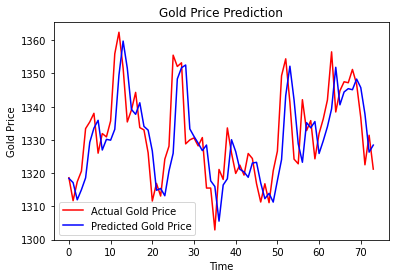

In [24]:
# Visualizing the results for CCN-LSTM-1 Model for forecasting horizon = 6
plot_predictions(y_test_real_price,predicted_y_test_real_price)

## Creating CNN-LSTM-2 Model for forecasting horizon = 4

In [25]:
# CNN-LSTM-2 model
model2 = Sequential()
# define CNN model
model2.add(TimeDistributed(Conv1D(filters = 64, kernel_size = 2, activation = 'relu', padding='same'), input_shape = (None,X_train_re.shape[2],1)))
model2.add(TimeDistributed(Conv1D(filters = 128, kernel_size = 2, activation='relu', padding='same')))
model2.add(TimeDistributed(MaxPooling1D(pool_size = 2)))
model2.add(TimeDistributed(Flatten()))
# define LSTM model
model2.add(LSTM(units = 200))
# define Fully-connected layer
model2.add(Dense(32, activation='relu'))
# define Output layer
model2.add(Dense(1))
# compile the model
model2.compile(optimizer='adam',loss='mean_squared_error')
model2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_5 (TimeDist (None, None, 4, 64)       192       
_________________________________________________________________
time_distributed_6 (TimeDist (None, None, 4, 128)      16512     
_________________________________________________________________
time_distributed_7 (TimeDist (None, None, 2, 128)      0         
_________________________________________________________________
time_distributed_8 (TimeDist (None, None, 256)         0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 200)               365600    
_________________________________________________________________
dense_2 (Dense)              (None, 32)                6432      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

In [26]:
model2.fit(X_train_re, y_train, epochs=50, batch_size=128, verbose=True)

Epoch 1/50
992/992 [==============================] - 1s 734us/step - loss: 0.2538
Epoch 2/50
992/992 [==============================] - 0s 100us/step - loss: 0.0367
Epoch 3/50
992/992 [==============================] - 0s 105us/step - loss: 0.0120
Epoch 4/50
992/992 [==============================] - 0s 97us/step - loss: 0.0124
Epoch 5/50
992/992 [==============================] - 0s 96us/step - loss: 0.0049
Epoch 6/50
992/992 [==============================] - 0s 96us/step - loss: 0.0032
Epoch 7/50
992/992 [==============================] - 0s 92us/step - loss: 0.0023
Epoch 8/50
992/992 [==============================] - 0s 95us/step - loss: 0.0019
Epoch 9/50
992/992 [==============================] - 0s 88us/step - loss: 0.0016
Epoch 10/50
992/992 [==============================] - 0s 96us/step - loss: 0.0015
Epoch 11/50
992/992 [==============================] - 0s 80us/step - loss: 0.0014
Epoch 12/50
992/992 [==============================] - 0s 97us/step - loss: 0.0014
Epoch 13/5

In [27]:
predicted_y_test2 = model2.predict(X_test_re)

## Results of CNN-LSTM-2 model for forecasting horizon = 4

In [28]:
return_rmse(y_test,predicted_y_test2)

Mean absolute error, MAE = 0.024199435126076085
Root mean squared error, RMSE = 0.03024535296089957


In [29]:
predicted_y_test_real_price2 = np.exp(sc.inverse_transform(predicted_y_test2))
y_test_real_price = np.exp(sc.inverse_transform(y_test.reshape(-1,1)))

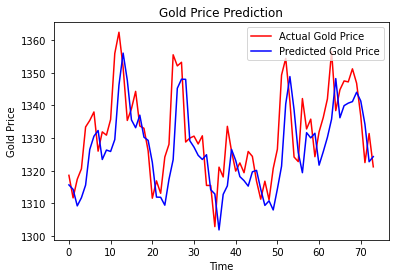

In [30]:
# Visualizing the results for CCN-LSTM-2 Model for forecasting horizon = 4
plot_predictions(y_test_real_price,predicted_y_test_real_price2)

# Model Predictions for Forecasting Horizon = 6 days

In [31]:
# Forecasting Horizon = 6 days
X_train, y_train = cal_X_y(training_set_scaled, 6)
X_test, y_test = cal_X_y(testing_set_scaled, 6)

In [32]:
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1],1)
X_test = X_test.reshape((X_test.shape[0],X_train.shape[1],1))

In [33]:
X_train_re = X_train.reshape((X_train.shape[0],1,X_train.shape[1],1))
X_test_re = X_test.reshape((X_test.shape[0],1,X_train.shape[1],1))

In [34]:
y_train = np.reshape(y_train, (y_train.shape[0],))
y_test = np.reshape(y_test, (y_test.shape[0],))

## Creating CNN-LSTM-1 Model for forecasting horizon = 6

In [35]:
# CNN-LSTM1 model
model1 = Sequential()
# define CNN model
model1.add(TimeDistributed(Conv1D(filters = 32, kernel_size = 2, activation = 'relu', padding='same'), input_shape = (None,X_train_re.shape[2],1)))
model1.add(TimeDistributed(Conv1D(filters = 64, kernel_size = 2, activation='relu', padding='same')))
model1.add(TimeDistributed(MaxPooling1D(pool_size = 2)))
model1.add(TimeDistributed(Flatten()))
# define LSTM model
model1.add(LSTM(units = 100))
# define the Output layer
model1.add(Dense(1))
# compile the model
model1.compile(optimizer='adam',loss='mean_squared_error')
model1.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_9 (TimeDist (None, None, 6, 32)       96        
_________________________________________________________________
time_distributed_10 (TimeDis (None, None, 6, 64)       4160      
_________________________________________________________________
time_distributed_11 (TimeDis (None, None, 3, 64)       0         
_________________________________________________________________
time_distributed_12 (TimeDis (None, None, 192)         0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 100)               117200    
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 101       
Total params: 121,557
Trainable params: 121,557
Non-trainable params: 0
________________________________________________

In [36]:
model1.fit(X_train_re, y_train, epochs=50, batch_size=128, verbose=True)

Epoch 1/50
988/988 [==============================] - 1s 684us/step - loss: 0.1816
Epoch 2/50
988/988 [==============================] - 0s 49us/step - loss: 0.0245
Epoch 3/50
988/988 [==============================] - 0s 52us/step - loss: 0.0098
Epoch 4/50
988/988 [==============================] - 0s 50us/step - loss: 0.0100
Epoch 5/50
988/988 [==============================] - 0s 52us/step - loss: 0.0037
Epoch 6/50
988/988 [==============================] - 0s 52us/step - loss: 0.0032
Epoch 7/50
988/988 [==============================] - 0s 52us/step - loss: 0.0024
Epoch 8/50
988/988 [==============================] - 0s 61us/step - loss: 0.0022
Epoch 9/50
988/988 [==============================] - 0s 57us/step - loss: 0.0021
Epoch 10/50
988/988 [==============================] - 0s 58us/step - loss: 0.0020
Epoch 11/50
988/988 [==============================] - 0s 58us/step - loss: 0.0020
Epoch 12/50
988/988 [==============================] - 0s 56us/step - loss: 0.0020
Epoch 13/50


In [37]:
predicted_y_test = model1.predict(X_test_re)

### Results of CNN-LSTM-1 model for forecasting horizon = 6

In [38]:
return_rmse(y_test,predicted_y_test)

Mean absolute error, MAE = 0.022891001353399026
Root mean squared error, RMSE = 0.029235402835059144


In [39]:
predicted_y_test_real_price = np.exp(sc.inverse_transform(predicted_y_test))
y_test_real_price = np.exp(sc.inverse_transform(y_test.reshape(-1,1)))

In [40]:
return_rmse(y_test_real_price,predicted_y_test_real_price)

Mean absolute error, MAE = 8.293894740513364
Root mean squared error, RMSE = 10.605948671543356


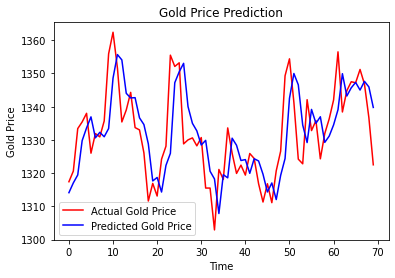

In [41]:
# Visualizing the results for CCN-LSTM-1 Model for forecasting horizon = 6
plot_predictions(y_test_real_price,predicted_y_test_real_price)

## Creating CNN-LSTM-2 Model for forecasting horizon = 6

In [42]:
# CNN-LSTM-2 model
model2 = Sequential()
# define CNN model
model2.add(TimeDistributed(Conv1D(filters = 64, kernel_size = 2, activation = 'relu', padding='same'), input_shape = (None,X_train_re.shape[2],1)))
model2.add(TimeDistributed(Conv1D(filters = 128, kernel_size = 2, activation='relu', padding='same')))
model2.add(TimeDistributed(MaxPooling1D(pool_size = 2)))
model2.add(TimeDistributed(Flatten()))
# define LSTM model
model2.add(LSTM(units = 200))
# define Fully-connected layer
model2.add(Dense(32, activation='relu'))
# define Output layer
model2.add(Dense(1))
# compile the model
model2.compile(optimizer='adam',loss='mean_squared_error')
model2.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_13 (TimeDis (None, None, 6, 64)       192       
_________________________________________________________________
time_distributed_14 (TimeDis (None, None, 6, 128)      16512     
_________________________________________________________________
time_distributed_15 (TimeDis (None, None, 3, 128)      0         
_________________________________________________________________
time_distributed_16 (TimeDis (None, None, 384)         0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 200)               468000    
_________________________________________________________________
dense_5 (Dense)              (None, 32)                6432      
_________________________________________________________________
dense_6 (Dense)              (None, 1)                

In [43]:
model2.fit(X_train_re, y_train, epochs=50, batch_size=128, verbose=True)

Epoch 1/50
988/988 [==============================] - 1s 948us/step - loss: 0.1929
Epoch 2/50
988/988 [==============================] - 0s 144us/step - loss: 0.0300
Epoch 3/50
988/988 [==============================] - 0s 142us/step - loss: 0.0152
Epoch 4/50
988/988 [==============================] - 0s 136us/step - loss: 0.0057
Epoch 5/50
988/988 [==============================] - 0s 122us/step - loss: 0.0041
Epoch 6/50
988/988 [==============================] - 0s 122us/step - loss: 0.0031
Epoch 7/50
988/988 [==============================] - 0s 137us/step - loss: 0.0024
Epoch 8/50
988/988 [==============================] - 0s 132us/step - loss: 0.0020
Epoch 9/50
988/988 [==============================] - 0s 136us/step - loss: 0.0019
Epoch 10/50
988/988 [==============================] - 0s 113us/step - loss: 0.0018
Epoch 11/50
988/988 [==============================] - 0s 134us/step - loss: 0.0018
Epoch 12/50
988/988 [==============================] - 0s 127us/step - loss: 0.0018
E

In [44]:
predicted_y_test2 = model2.predict(X_test_re)

## Results of CNN-LSTM-2 model for forecasting horizon = 6

In [45]:
return_rmse(y_test,predicted_y_test2)

Mean absolute error, MAE = 0.021992182642830826
Root mean squared error, RMSE = 0.028048963433942448


In [46]:
predicted_y_test_real_price2 = np.exp(sc.inverse_transform(predicted_y_test2))
y_test_real_price = np.exp(sc.inverse_transform(y_test.reshape(-1,1)))

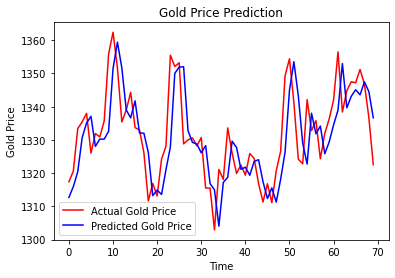

In [47]:
# Visualizing the results for CCN-LSTM2 Model for forecasting horizon = 6
plot_predictions(y_test_real_price,predicted_y_test_real_price2)

# Model Predictions for Forecasting Horizon = 9 days

In [48]:
# Forecasting Horizon = 9 days
X_train, y_train = cal_X_y(training_set_scaled, 9)
X_test, y_test = cal_X_y(testing_set_scaled, 9)

In [49]:
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1],1)
X_test = X_test.reshape((X_test.shape[0],X_train.shape[1],1))

In [50]:
X_train_re = X_train.reshape((X_train.shape[0],1,X_train.shape[1],1))
X_test_re = X_test.reshape((X_test.shape[0],1,X_train.shape[1],1))

In [51]:
y_train = np.reshape(y_train, (y_train.shape[0],))
y_test = np.reshape(y_test, (y_test.shape[0],))

## Creating CNN-LSTM-1 Model for forecasting horizon = 9

In [52]:
# CNN-LSTM1 model
model1 = Sequential()
# define CNN model
model1.add(TimeDistributed(Conv1D(filters = 32, kernel_size = 2, activation = 'relu', padding='same'), input_shape = (None,X_train_re.shape[2],1)))
model1.add(TimeDistributed(Conv1D(filters = 64, kernel_size = 2, activation='relu', padding='same')))
model1.add(TimeDistributed(MaxPooling1D(pool_size = 2)))
model1.add(TimeDistributed(Flatten()))
# define LSTM model
model1.add(LSTM(units = 100))
# define the Output layer
model1.add(Dense(1))
# compile the model
model1.compile(optimizer='adam',loss='mean_squared_error')
model1.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_17 (TimeDis (None, None, 9, 32)       96        
_________________________________________________________________
time_distributed_18 (TimeDis (None, None, 9, 64)       4160      
_________________________________________________________________
time_distributed_19 (TimeDis (None, None, 4, 64)       0         
_________________________________________________________________
time_distributed_20 (TimeDis (None, None, 256)         0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 100)               142800    
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 101       
Total params: 147,157
Trainable params: 147,157
Non-trainable params: 0
________________________________________________

In [53]:
model1.fit(X_train_re, y_train, epochs=50, batch_size=128, verbose=True)

Epoch 1/50
982/982 [==============================] - 1s 827us/step - loss: 0.2265
Epoch 2/50
982/982 [==============================] - 0s 73us/step - loss: 0.0283
Epoch 3/50
982/982 [==============================] - 0s 72us/step - loss: 0.0161
Epoch 4/50
982/982 [==============================] - 0s 66us/step - loss: 0.0120
Epoch 5/50
982/982 [==============================] - 0s 62us/step - loss: 0.0057
Epoch 6/50
982/982 [==============================] - 0s 67us/step - loss: 0.0050
Epoch 7/50
982/982 [==============================] - 0s 62us/step - loss: 0.0036
Epoch 8/50
982/982 [==============================] - 0s 63us/step - loss: 0.0032
Epoch 9/50
982/982 [==============================] - 0s 66us/step - loss: 0.0031
Epoch 10/50
982/982 [==============================] - 0s 66us/step - loss: 0.0030
Epoch 11/50
982/982 [==============================] - 0s 64us/step - loss: 0.0029
Epoch 12/50
982/982 [==============================] - 0s 82us/step - loss: 0.0029
Epoch 13/50


In [54]:
predicted_y_test = model1.predict(X_test_re)

### Results of CNN-LSTM-1 model for forecasting horizon = 9

In [55]:
return_rmse(y_test,predicted_y_test)

Mean absolute error, MAE = 0.023729339556313178
Root mean squared error, RMSE = 0.0308845582579297


In [56]:
predicted_y_test_real_price = np.exp(sc.inverse_transform(predicted_y_test))
y_test_real_price = np.exp(sc.inverse_transform(y_test.reshape(-1,1)))

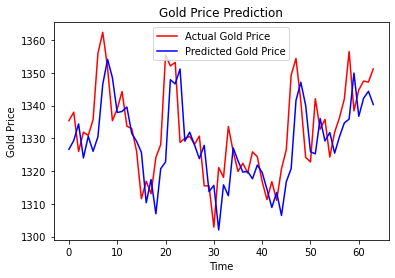

In [57]:
# Visualizing the results for CCN-LSTM-1 Model for forecasting horizon = 9
plot_predictions(y_test_real_price,predicted_y_test_real_price)

## Creating CNN-LSTM-2 Model for forecasting horizon = 9

In [58]:
# CNN-LSTM-2 model
model2 = Sequential()
# define CNN model
model2.add(TimeDistributed(Conv1D(filters = 64, kernel_size = 2, activation = 'relu', padding='same'), input_shape = (None,X_train_re.shape[2],1)))
model2.add(TimeDistributed(Conv1D(filters = 128, kernel_size = 2, activation='relu', padding='same')))
model2.add(TimeDistributed(MaxPooling1D(pool_size = 2)))
model2.add(TimeDistributed(Flatten()))
# define LSTM model
model2.add(LSTM(units = 200))
# define Fully-connected layer
model2.add(Dense(32, activation='relu'))
# define Output layer
model2.add(Dense(1))
# compile the model
model2.compile(optimizer='adam',loss='mean_squared_error')
model2.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_21 (TimeDis (None, None, 9, 64)       192       
_________________________________________________________________
time_distributed_22 (TimeDis (None, None, 9, 128)      16512     
_________________________________________________________________
time_distributed_23 (TimeDis (None, None, 4, 128)      0         
_________________________________________________________________
time_distributed_24 (TimeDis (None, None, 512)         0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 200)               570400    
_________________________________________________________________
dense_8 (Dense)              (None, 32)                6432      
_________________________________________________________________
dense_9 (Dense)              (None, 1)                

In [59]:
model2.fit(X_train_re, y_train, epochs=50, batch_size=128, verbose=True)

Epoch 1/50
982/982 [==============================] - 1s 1ms/step - loss: 0.1866
Epoch 2/50
982/982 [==============================] - 0s 166us/step - loss: 0.0312
Epoch 3/50
982/982 [==============================] - 0s 145us/step - loss: 0.0160
Epoch 4/50
982/982 [==============================] - 0s 142us/step - loss: 0.0073
Epoch 5/50
982/982 [==============================] - 0s 162us/step - loss: 0.0063
Epoch 6/50
982/982 [==============================] - 0s 151us/step - loss: 0.0046
Epoch 7/50
982/982 [==============================] - 0s 168us/step - loss: 0.0037
Epoch 8/50
982/982 [==============================] - 0s 154us/step - loss: 0.0033
Epoch 9/50
982/982 [==============================] - 0s 150us/step - loss: 0.0031
Epoch 10/50
982/982 [==============================] - 0s 149us/step - loss: 0.0030
Epoch 11/50
982/982 [==============================] - 0s 146us/step - loss: 0.0029
Epoch 12/50
982/982 [==============================] - 0s 154us/step - loss: 0.0029
Epo

In [60]:
predicted_y_test2 = model2.predict(X_test_re)

## Results of CNN-LSTM-2 model for forecasting horizon = 9

In [61]:
return_rmse(y_test,predicted_y_test2)

Mean absolute error, MAE = 0.02367418850568892
Root mean squared error, RMSE = 0.029889474094856677


In [62]:
predicted_y_test_real_price2 = np.exp(sc.inverse_transform(predicted_y_test2))
y_test_real_price = np.exp(sc.inverse_transform(y_test.reshape(-1,1)))

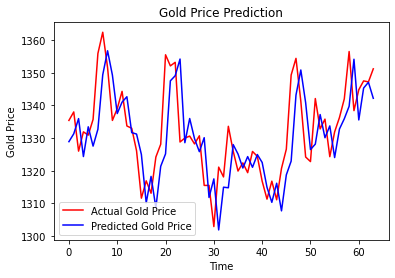

In [63]:
# Visualizing the results for CCN-LSTM2 Model for forecasting horizon = 9
plot_predictions(y_test_real_price,predicted_y_test_real_price2)